# Cancer Mortality Exploration

Zeliang (Doug) Xu, Arjun Chakraborty, John Boudreaux

_An exploratory analysis of county characteristics as they relate to cancer death rates_

## Introduction
This exploratory analysis is meant to address the research question: 

__What factors are related to the cancer death rate in US counties?__

By looking at the dataset and our general intuition about cancer, we believe that there are two major sources of contributing factors that lead to higher cancer death rate for each physical region:

* Higher cancer occurance rates will lead to more cases of cancer deaths in a particular region
* Worse cancer treatment facilities, policies, personnel, etc. will lead to more cancer deaths in a particular region

To explore this research question and sub-topics, we will employ various statistical techniques including subsetting the data, descriptive statistics, outlier detection and treatment, multivariate correlations, and others. In particular, our analysis will focus heavily on using graphical methods to illustrate various aspects about our dataset. We find certain relationships, particularly in the area of insurance coverage, that prove interesting as levers for policy change.

It is important to note that our analysis is not meant to prove any sort of causality. All of our methods and conclusions are purely meant as descriptive methods to explore the relationships within the data. Additionally, this dataset has some very particular issues that indicate further data collection or clarification may be necessary to fully validate the results. For instance, there is no documentation on the basis of the death rate- is this a death rate per 100,000 people, averaged over some period? Is it normalized in any way? Is it only deaths from cancer? Without further documentation, we can still perform some analysis but still need to clarify some assumptions before action can be responsibly taken.

In this report, we will use R (>=3.4) to perform the analysis. We will provide code for all graphics and analysis performed so that the reader can reproduce this analysis with the given dataset.

## Data Preparation

Below is a collection of libraries that we use for the study:

In [33]:
library(car)   # to enable csv import, plots functions
library(stringr)   # to enable string splitting
library(corrplot)   # to enable corrplot
library(data.table)   # to be able to change the indexing of data frame
options(repr.plot.width=5, repr.plot.height=4)

In [34]:
#may need to change address depending on where you have it saved
data <- read.csv("../project materials/cancer.csv")

In [51]:
dim(data)

[1] 3047   33

Our data has 3047 observations of 30 variables. These dimensions ought to be sufficient for many subsetting operations we may want to do with the data. The variables all describe different properties of US counties, primarily focusing on demographic data.

In [52]:
summary(data)

       X           avgAnnCount        medIncome        popEst2015      
 Min.   :   1.0   Min.   :    6.0   Min.   : 22640   Min.   :     827  
 1st Qu.: 762.5   1st Qu.:   76.0   1st Qu.: 38883   1st Qu.:   11684  
 Median :1524.0   Median :  171.0   Median : 45207   Median :   26643  
 Mean   :1524.0   Mean   :  606.3   Mean   : 47063   Mean   :  102637  
 3rd Qu.:2285.5   3rd Qu.:  518.0   3rd Qu.: 52492   3rd Qu.:   68671  
 Max.   :3047.0   Max.   :38150.0   Max.   :125635   Max.   :10170292  
                                                                       
 povertyPercent               binnedInc      MedianAge     MedianAgeMale  
 Min.   : 3.20   (45201, 48021.6]  : 306   Min.   :22.30   Min.   :22.40  
 1st Qu.:12.15   (54545.6, 61494.5]: 306   1st Qu.:37.70   1st Qu.:36.35  
 Median :15.90   [22640, 34218.1]  : 306   Median :40.90   Median :39.60  
 Mean   :16.88   (42724.4, 45201]  : 305   Mean   :40.82   Mean   :39.57  
 3rd Qu.:20.40   (48021.6, 51046.4]: 305   3rd Qu

There are a few peculiarities in the data that we must address before going further. First, over half of our observations for `PctSomeCol18_24` are missing values. We should be wary of any sort of statistically significant results we obtain with this variable, since sampling effects will likely alter some of the true dynamics in the data. There are also missing values in `PctEmployed16_Over`, but this is a much smaller number and does not necessarily warrant the same degree of caution for `PctSomeCol18_24`.

In addition to missing values, there are some values that don't make a ton of sense with reality. Looking at the columns denoting race (`PctWhite`, `PctBlack`, `PctAsian`, `PctOtherRace`) it does not seem intuitive that any county in the US would truly be 100% or 0% any value. When we check to see if the total sum of all races adds up to 100, we see that there are many examples that do not come close to 100% accounted for, with over 10% of observations not adding up to 95%. Our analysis will not focus deeply on race relationships, due to the subadequate data.

The details of data for total race percentage is: 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.23   96.41   97.70   95.99   98.42  100.00 

There are 421 rows of data with total race percentage smaller than 95%
There are 24 rows of data with total race percentage smaller than 50%
There are 6 rows of data with total race percentage smaller than 20%


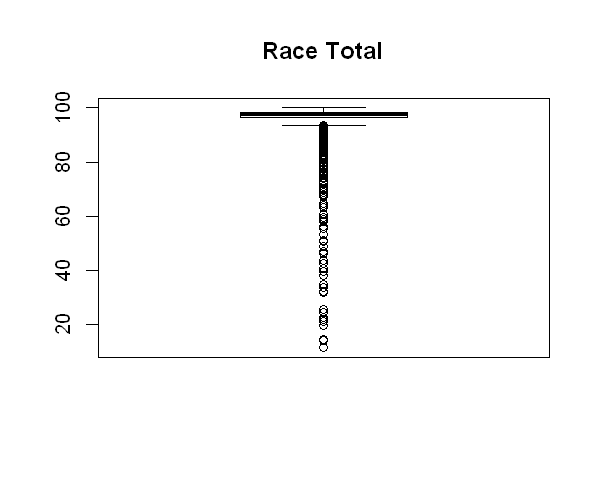

In [36]:
data$total_race <- data$PctAsian + data$PctBlack + data$PctWhite + data$PctOtherRace
message("The details of data for total race percentage is: ")
summary(data$total_race)
message("There are ",nrow(subset(data,data$total_race < 95)), " rows of data with total race percentage smaller than 95%")
message("There are ",nrow(subset(data,data$total_race < 50)), " rows of data with total race percentage smaller than 50%")
message("There are ",nrow(subset(data,data$total_race < 20)), " rows of data with total race percentage smaller than 20%")

boxplot(data$total_race, main = "Race Total")

When we look at the `MedianAge` column, we see some unreasonable high outliers. By examining the boxplot below, we found that values above 65 were nonsensical. These were assigned the `NA` value to be exlcuded from further analysis. This should not effect the analysis much, as these are only 31 values being removed (~1% total observations).

[1] 31

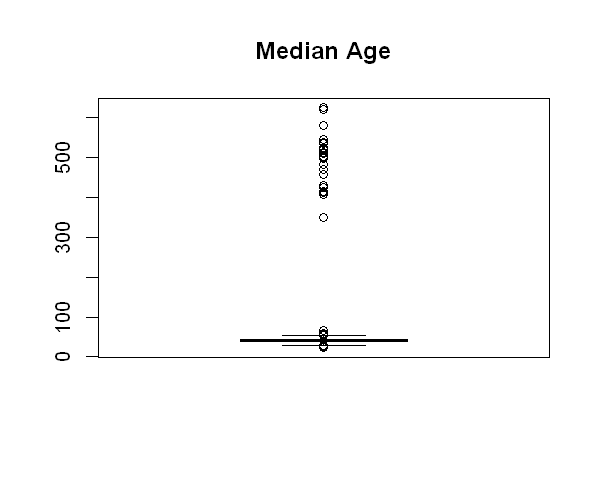

In [37]:
boxplot(data$MedianAge, main = "Median Age")

#filter out outliers
data$MedianAge[data$MedianAge > 65] <- NA
sum(is.na(data$MedianAge))

We also found that there are 61 instances of an Average Household Size being less than 1. While this may have some reasoning in real life such as secondary properties, there was no such documentation to confirm this. As such, we removed all values less than 1 since this does not make sense with our default assumptions that one person must live in a place for it to be considered a household. Again, this is a small amount of observations and should not effect many results in a major way.

[1] 61

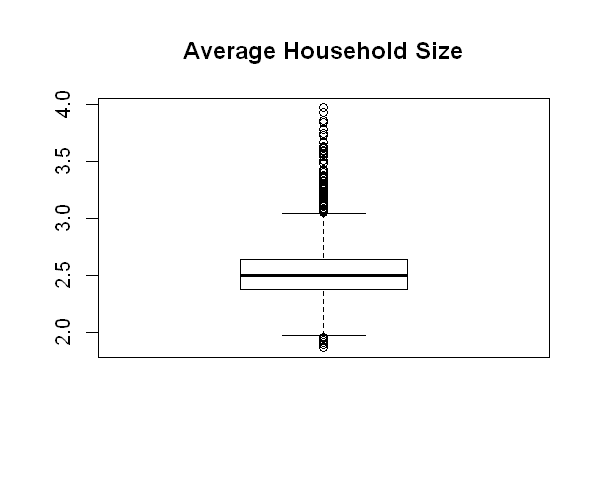

In [40]:
boxplot(data$AvgHouseholdSize, 
        main = "Average Household Size")

data$AvgHouseholdSize[data$AvgHouseholdSize < 1] <- NA
sum(is.na(data$AvgHouseholdSize))

We found one value where `PctHS18_24` was zero. In the US, it is difficult to believe that not one person in any given county has completed high school. We take away this value from further analysis. 

In [42]:
data$PctHS18_24[data$PctHS18_24 == 0] <- NA
sum(is.na(data$PctHS18_24))

[1] 1

The population data in `popEst2015` shows very heavy skew towards lower values, but the higher values also make sense for the hyper-urbanized areas such as Los Angeles, Chicago, New York, and the others that they represent. In this case, a log transformation could prove useful for further analysis to have a more uniform distribution of values.

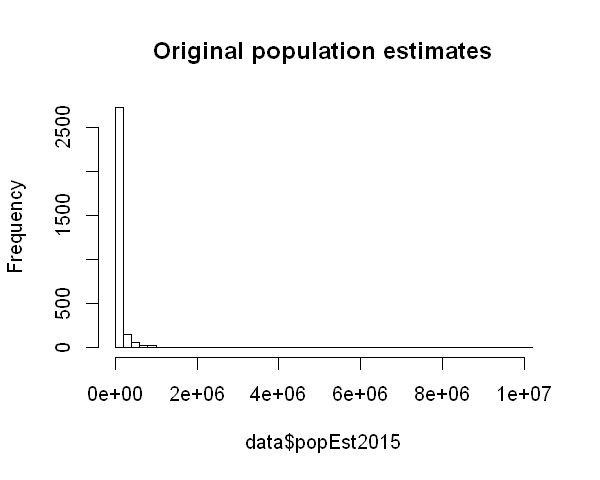

In [53]:
hist(data$popEst2015, , breaks = 50, main = "Original population estimates")

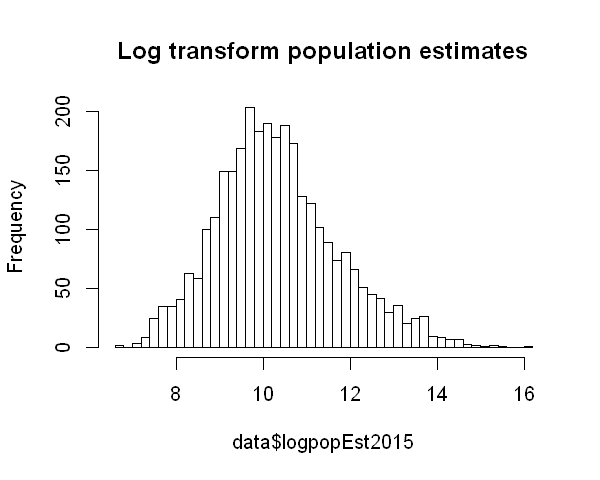

In [54]:
data$logpopEst2015 <- log(data$popEst2015)
hist(data$logpopEst2015, breaks = 50, main = "Log transform population estimates")

The last major item we have to address is the variables that are factors. The `binnedInc` column contains a categorical value for the bracket of the median income. Since this value is inherently contained by the `MedIncome` variable, we largely ignored this category since we can just as easily subset it on our own. There is another value that contains structured data in a string format in the `Geography` field, which gives the unique county for each observation. Individual counties are probably not so useful, but having the states as a factor to subset the data could prove useful.

In [55]:
#create the state column
data$Geography <- as.character(data$Geography)
split.geo <- strsplit(as.character(data$Geography), ", ")
states <- sapply(split.geo, 
                 function(x){
                   return(x[2])
                   })
data$state <- as.factor(states)
sample(data$state, 5)

[1] Washington Virginia   Minnesota  Iowa       Colorado  
51 Levels: Alabama Alaska Arizona Arkansas California Colorado ... Wyoming

## Exploratory Data Analysis

Given that our overall target is to better understand the death rate due to cancer, it probably makes most sense to look at this variable first. We see that it appears to follow more or less of a Gaussian curve _(note: refraining from implenting tests for normality until they are covered in course material)._ 

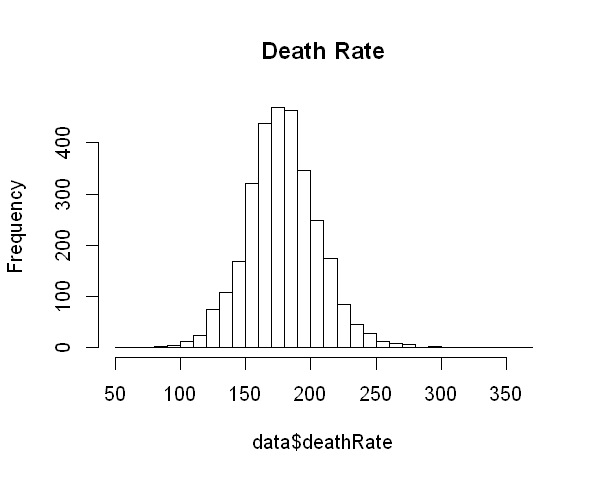

In [56]:
hist(data$deathRate, breaks = 40, main = "Death Rate")

To give guidance into what relationships in our data might be more interesting than others, we used the `corrplot` function from the `corrplot` package. This gives a visualization of the strength of the Pearson corrlation between various parameters. We note that we used a specific setting to only include values in which both observations were defined in calculating the Pearson coefficient (any `NA` values excluded). In this graphic, color <font color=blue>__blue__</font> represents positive correlation factor while color <font color=red>__red__</font> represents negative correlation. White indicates there is no clear correlation between the variables.

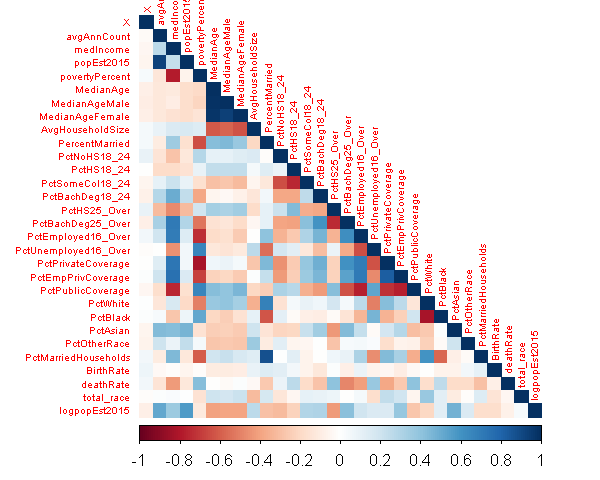

In [64]:
# only include numerical columns in correlation matrix
numeric.cols <- as.logical(unlist(lapply(data, is.numeric)))
corr.matrix <- cor(data[,numeric.cols], use = "pairwise.complete.obs")

corrplot(corr.matrix, is.corr=T , 
         method = "color", 
         type='lower',
         tl.cex = 0.5)